 HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.  
 
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.  

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.   



__Первая__ — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.   

__Вторая задача__ — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.  

__id__ — уникальный идентификатор сотрудника;  
__dept__ — отдел, в котором работает сотрудник;  
__level__ — уровень занимаемой должности;  
__workload__ — уровень загруженности сотрудника;  
__employment_years__ — длительность работы в компании (в годах);  
__last_year_promo__ — показывает, было ли повышение за последний год;  
__last_year_violations__ — показывает, нарушал ли сотрудник трудовой договор за последний год;  
__supervisor_evaluation__ — оценка качества работы сотрудника, которую дал руководитель;  
__salary__ — ежемесячная зарплата сотрудника;  
__job_satisfaction_rate__ — уровень удовлетворённости сотрудника работой в компании, целевой признак.  

In [1]:
!pip install -U seaborn
!pip install -U scikit-learn
!pip install optuna
!pip install shap
!pip install phik

     |████████████████████████████████| 294 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 18.1 MB/s eta 0:00:01     |██████████████████████████████▋ | 11.1 MB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 310 kB 79.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 79.0 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
     |████████████████████████████████| 10.9 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 95.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                    cross_val_score)
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

# загружаем нужные модели
from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeRegressor

from optuna.integration import OptunaSearchCV
from sklearn.compose import ColumnTransformer
from optuna import distributions
from collections import defaultdict
from sklearn.metrics import make_scorer

import phik

from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
RANDOM_STATE = 42
TEST_SIZE =0.25

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Загружаем данные

In [4]:
try: 
    test = pd.read_csv('practicum\df_sp08\test_features.csv')
    test_target = pd.read_csv('practicum\df_sp08\test_target_job_satisfaction_rate.csv')
    train = pd.read_csv('practicum\df_sp08\train_job_satisfaction_rate.csv')
    test_target_quit = pd.read_csv('practicum\df_sp08\/test_target_quit.csv')
    train_quit = pd.read_csv('practicum\df_sp08\/train_quit.csv')
except:
    test_basa = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

## Предобработка данных

In [5]:
test = test_basa.copy()

In [6]:
def Load_info(df):
    display(df.head())
    print('*'*50)
    display(df.describe().T)
    print('*'*50)   
    display(df.info())
    print('*'*50)
    print('Кол-во дубликатов : ',df.duplicated().sum())
    print('*'*50)   

In [7]:
Load_info(test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


**************************************************


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


In [8]:
Load_info(test_target)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**************************************************


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


In [9]:
Load_info(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


**************************************************


,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


### Проверяем на наличие NaN

In [10]:
df = [train, test, test_target]
for i in df:
    print(i.isna().sum())
    print('*'*50)


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
**************************************************
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
**************************************************
id                       0
job_satisfaction_rate    0
dtype: int64
**************************************************


__Заполняем пропущенные поля модовыми значениями__

In [11]:
df = [train, test, test_target] # проверяем после замены
for i in df:
    print(i.isna().sum())
    print('*'*50)


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
**************************************************
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
**************************************************
id                       0
job_satisfaction_rate    0
dtype: int64
**************************************************


In [12]:
test.columns# проверяем название колонок

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [13]:
train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [14]:
columns = test.select_dtypes(include='object').columns.to_list()
for i in columns:
    display(test[i].unique())
    display(test[i].value_counts())
    print('*'* 50)

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

**************************************************


array(['junior', 'middle', 'sinior', nan], dtype=object)

junior    974
middle    854
sinior    171
Name: level, dtype: int64

**************************************************


array(['medium', 'low', 'high', ' '], dtype=object)

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

**************************************************


array(['no', 'yes'], dtype=object)

no     1937
yes      63
Name: last_year_promo, dtype: int64

**************************************************


array(['no', 'yes'], dtype=object)

no     1738
yes     262
Name: last_year_violations, dtype: int64

**************************************************


In [15]:
columns = train.select_dtypes(include='object').columns.to_list()
for i in columns:
    display(train[i].unique())
    display(train[i].value_counts())
    print('*'* 50)

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

**************************************************


array(['junior', 'middle', 'sinior', nan], dtype=object)

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

**************************************************


array(['medium', 'high', 'low'], dtype=object)

medium    2066
low       1200
high       734
Name: workload, dtype: int64

**************************************************


array(['no', 'yes'], dtype=object)

no     3880
yes     120
Name: last_year_promo, dtype: int64

**************************************************


array(['no', 'yes'], dtype=object)

no     3441
yes     559
Name: last_year_violations, dtype: int64

**************************************************


In [16]:
test.loc[test['workload']== ' ', 'workload'] = test['workload'].mode()[0] # меняем не заполненные значения поля на модовое значения
test.loc[test['dept']== ' ', 'dept'] = test['dept'].mode()[0]

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


__Вывод:__ Есть небольшие недочеты с данными но ни чего кретичного нет, все поправил, пропуски заменил модовыми значениями.

## Исследовательский анализ данных 

In [18]:
test_df = test.set_index('id') # объеденение двух тоблиц для последующего анализа
test_target_new = test_target.set_index('id')
union_test = test_df.join(test_target_new)
union_test = union_test.reset_index()

In [19]:
union_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [20]:
def disk_bar(df, df1, column, title=None):
    _, axes = plt.subplots(1, 2,figsize=(20,4))
    df.groupby(column)['id'].count().plot(kind = 'bar',  edgecolor='black'
                                                     , rot=0, title = title+' train', ax=axes[0]
                                                     , ylabel='кол-во', xlabel='год' )
    df1.groupby(column)['id'].count().plot(kind = 'bar',  edgecolor='black'
                                                     , rot=0, title = title+' test', ax=axes[1]
                                                     , ylabel='кол-во', xlabel='год', color='green' )

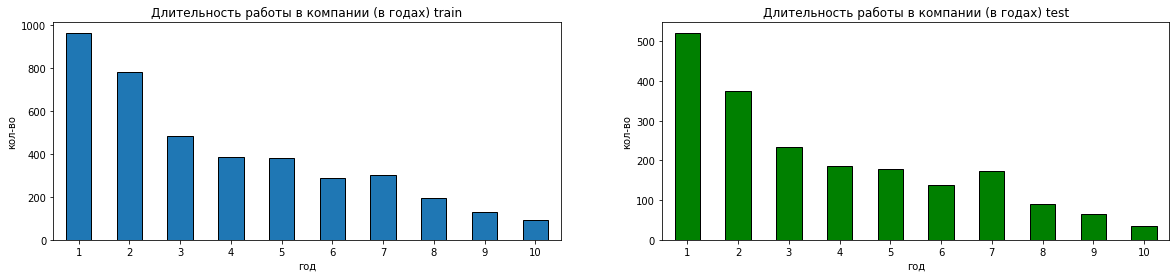

In [21]:
disk_bar(train, test, 'employment_years', 'Длительность работы в компании (в годах)')

Судя по графику в компании приобладают сотрудники с малым стажем в компании, это говорт о высокой "текучки" кадров

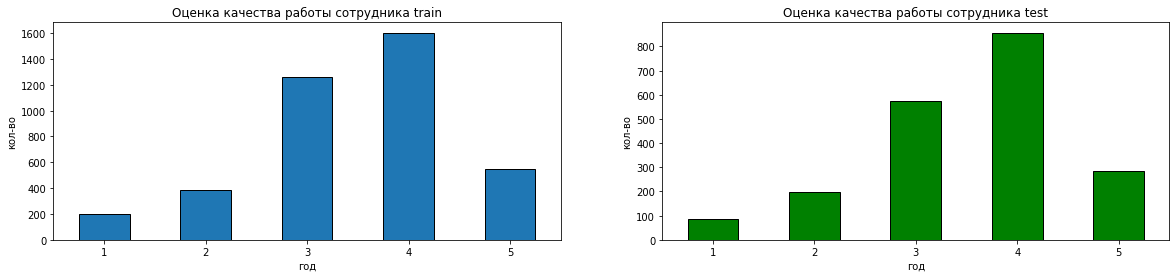

In [22]:
disk_bar(train, test, 'supervisor_evaluation', 'Оценка качества работы сотрудника')

Побовляющее большенство сотрудников работают довольно хоршо, максимум коллеблится между удовлетворительно и хорошо.

plot_feature_distribution(train, 'employment_years', 'Длительность работы в компании (в годах)')

plot_feature_distribution(train, 'supervisor_evaluation', 'Оценка качества работы сотрудника')

In [23]:
def plot_feature_distribution(df, df2, feature, title=None):
    # функция для построение графиков (колличественные данные)
    _, axes = plt.subplots(1, 2,figsize=(15,5))
    sns.histplot(data = df[feature], bins='auto', kde=True, multiple='dodge', ax=axes[0]).set(title=title+' train')
    sns.histplot(data = df2[feature], bins='auto', kde=True, multiple='dodge',ax=axes[1]).set(title=title+ ' test')
    plt.ylabel('Частота')
    plt.show()

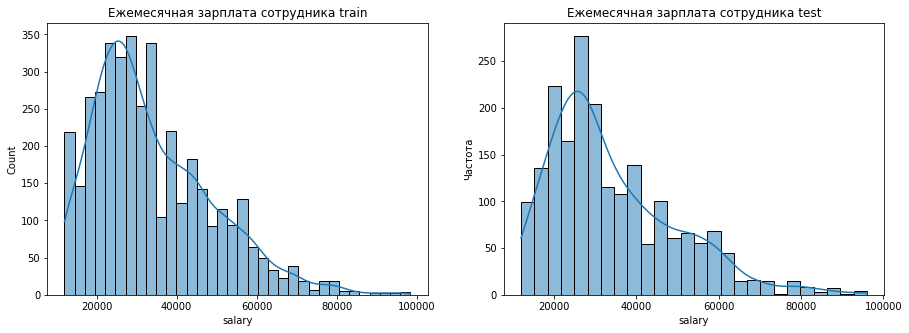

In [24]:
plot_feature_distribution(train, test,'salary', 'Ежемесячная зарплата сотрудника')

Медианная зарплата колеблится в районе 30000 и судя по графику разница между работающими за копейки и получающие максимум бовольно большая.

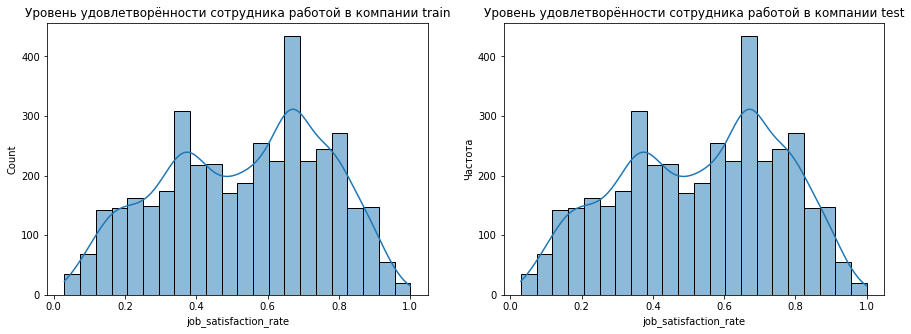

In [25]:
plot_feature_distribution(train, train,'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой в компании')

Удовлетворенность сотрудников работой в районе 0,5, не да не  нет.

In [26]:
def plot_categorical_distribution(df, df2, feature, title = None): # функция для построение графиков (котегориальные данные)
    _, axes = plt.subplots(1, 2,figsize=(15,5))
    df_for_hi = df.groupby(feature).size()/len(df)    
    df_for_hi.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True,  ax=axes[0],
                   title=title+' train',  wedgeprops={'linewidth':1, 'edgecolor':'white'})
    df_for_hi2 = df2.groupby(feature).size()/len(df2)    
    df_for_hi2.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True, ax=axes[1], 
                    title=title+' test',  wedgeprops={'linewidth':1, 'edgecolor':'white'})

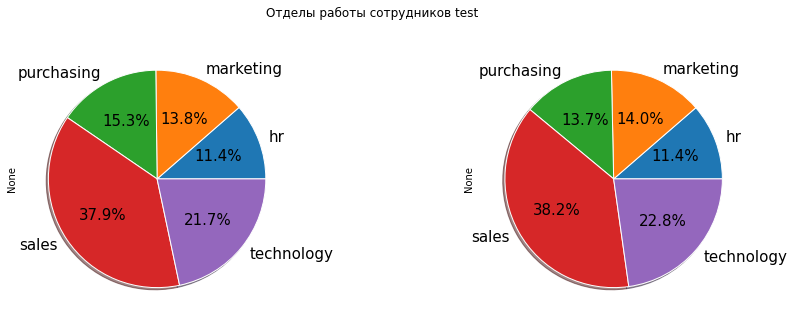

In [27]:
plot_categorical_distribution(train, test,'dept', 'Отделы работы сотрудников')

Почти 40% работников работают в отделе __продаж__ 

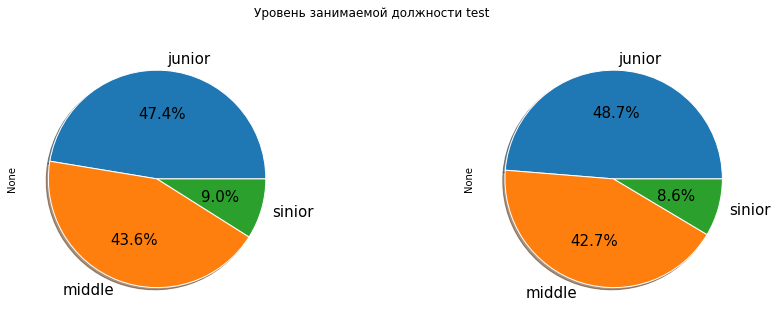

In [28]:
plot_categorical_distribution(train, test,'level', 'Уровень занимаемой должности')

Сотрудников с низкой квалификацией составляет 47,5%, со средней 4,36%, и высокой всего 9%

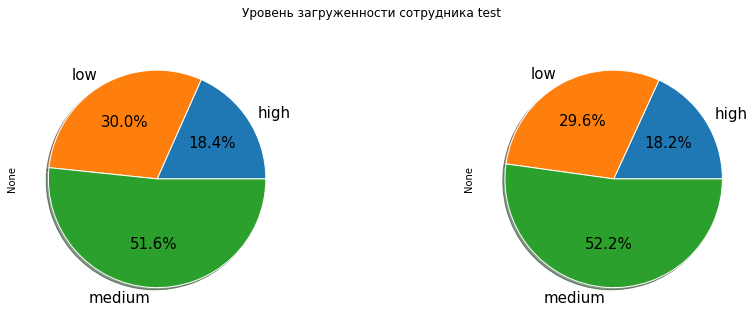

In [29]:
plot_categorical_distribution(train, test,'workload', 'Уровень загруженности сотрудника')

Довольно высокий показатель низкой загрудки сотрудников 30%, необходимо оптемизировать рабочий процес. 

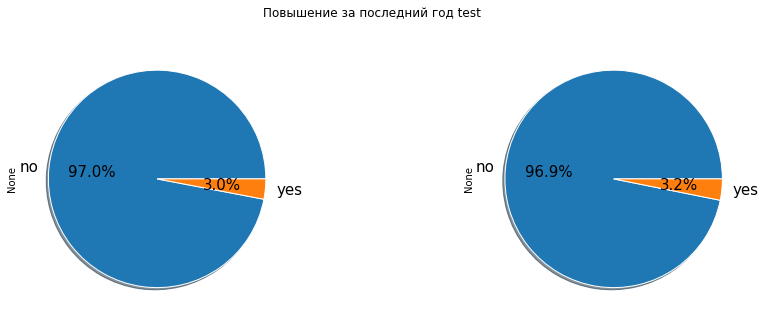

In [30]:
plot_categorical_distribution(train, test,'last_year_promo', 'Повышение за последний год')

Стимуляции работать более усердно нет 97% сотрудников, а туда и пополи спесиалисты с высокой квалефикацией не получали стимул к плодотворной работе.

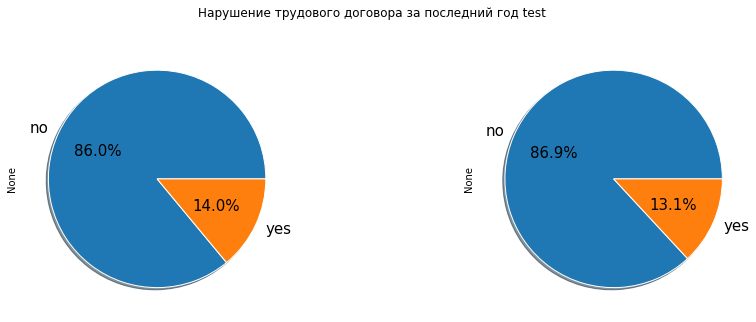

In [31]:
plot_categorical_distribution(train, test,'last_year_violations', 'Нарушение трудового договора за последний год')

14% человек нарушали трудовой договор (у этой компании большие порлблемы)

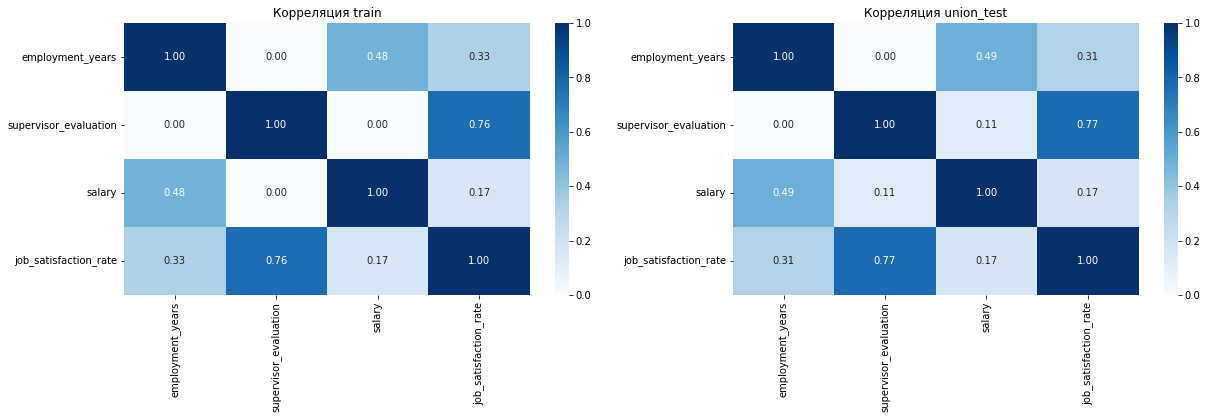

In [32]:
_, axes = plt.subplots(1, 2,figsize=(20,5))
columns =train.select_dtypes(exclude='object').columns.to_list()
columns.remove('id')
interval_cols = ['salary', 'job_satisfaction_rate']
sns.heatmap(train[columns].phik_matrix(interval_cols=interval_cols), cmap="Blues", annot=True,fmt='.2f', ax = axes[0]).set(title='Корреляция train')
sns.heatmap(union_test[columns].phik_matrix(interval_cols=interval_cols), cmap="Blues", annot=True,fmt='.2f', ax = axes[1]).set(title='Корреляция union_test')
pass

__Вывод:__   
Из данных выше, мы можем сказать, что сильнее всего коррелируются два параметра "job_satisfaction_rate" и "supervisor_evaluation" как в таблице train так и в таблице union_test, говорить о мультиколлинеарности покак рано так как значение не достигло 90%.

Многие из этих параметров оказывают довольно слабое влияние, но если попробовать их объединить в одну группу, то, наверняка, можно будет построить хорошую предсказательную модел.  

# Проверка на мультиколлинеарность #

In [33]:
def vif(db):
    columns =db.select_dtypes(exclude='object').columns.to_list()
    X = db[columns] # Выделяем "независимые" переменные (признаки)

    X_with_const = sm.add_constant(X) # Добавляем константу для использования модуля statsmodels

# Рассчитываем VIF для каждого признака
    vif = pd.DataFrame()
    vif['Feature'] = X_with_const.columns
    vif['vif'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    display(vif.round(2)) # Выводим результаты

In [34]:
vif(train)

,Feature,vif
0,const,23.15
1,id,1.00
2,employment_years,1.36
3,supervisor_evaluation,2.00
4,salary,1.28
5,job_satisfaction_rate,2.09


In [35]:
vif(union_test)

,Feature,vif
0,const,22.35
1,id,1.00
2,employment_years,1.35
3,supervisor_evaluation,2.07
4,salary,1.29
5,job_satisfaction_rate,2.18


___VIF (Variance Inflation Factor)___:  
    
VIF измеряет насколько дисперсия коэффициента увеличивается, когда предикторы коррелированы. Если VIF = 1, переменные не коррелированы. Если VIF > 5-10, то существует проблема мультиколлинеарности.
На основе полученных значений VIF можно сделать следующие выводы:  
    
const (константа): Значение VIF для константы 23,15. Это значение можно игнорировать. Важно помнить, что высокое значение VIF для константы не связано с мультиколлинеарностью между признаками;

Остальные признаки: Все признаки имеют значения VIF в диапазоне от 1 до 2,18. Это подтверждает вывод о том, что между признаками нет мультиколлинеарности. Самое высокое значение VIF (__2,09__) у признаков "job_satisfaction_rate" и чуть меньше "supervisor_evaluation", но даже эти значения находятся в приемлемом диапазоне.

__Вывод__: Нет признаков мультиколлинеарности между переменными.

## Подготовка данных

### Функция для вычисления итоговой smape

In [36]:
def smape(y_i, y_predicted_i,):
    N = len(y_i)
    return 100 * (2 * abs(y_i - y_predicted_i)/(abs(y_i) + abs(y_predicted_i))).sum() / N    

In [37]:
def prepare_data(X_train, y_train, X_test, y_test):# pipline подготовки данных
    
 
    ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
    ohe_columns.remove('workload')
    ohe_columns.remove('level')
    ord_columns = ['workload', 'level']
    num_columns = X_train.select_dtypes(exclude = 'object').columns.to_list()    
    
    # создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
    # SimpleImputer + OHE
    ohe_pipe = Pipeline(
        [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
        ]
        )

    # создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
    # SimpleImputer + OE
    ord_pipe = Pipeline(
        [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ord',  OrdinalEncoder(
                    handle_unknown='use_encoded_value', unknown_value=np.nan)
            ),
         ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ]
    )
    
    data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
    )
    
    X_train_ridge = X_train.copy()
    X_test_ridge = X_test.copy()
    y_train_ridge  = y_train.copy()
    y_test_ridge  = y_test.copy()
    
    X_train_ridge = pd.DataFrame(data_preprocessor.fit_transform(X_train_ridge), 
                                columns=data_preprocessor.get_feature_names_out()
                               )
    X_test_ridge = pd.DataFrame(data_preprocessor.transform(X_test_ridge), 
                                columns=data_preprocessor.get_feature_names_out()
                               )
    
    X_train_ridge = X_train_ridge.reset_index(drop=True)
    X_test_ridge  = X_test_ridge.reset_index(drop=True)
    y_train_ridge = y_train_ridge.reset_index(drop=True)
    y_test_ridge  = y_test_ridge.reset_index(drop=True)
   


    return X_train_ridge,  X_test_ridge,  y_train_ridge, y_test_ridge 

In [38]:
def get_cv_scores(model, target, features):# Функция кросс валидации которая вычисляет sMAPE
    my_scorer = make_scorer(smape, greater_is_better=False)
    
    scores = cross_val_score(model,
                             features,
                             target,
                             cv=5,
                             scoring=my_scorer)
    
    return scores.mean()

In [39]:
train_pip = train.copy()
train_pip = train_pip.sort_values(by='id').drop(['id'], axis=1).drop_duplicates()
test_pip = test.copy()
test_pip = test_pip.sort_values(by='id').drop(['id'], axis=1)

X_train_ridge,  X_test_ridge, y_train_ridge, y_test_ridge = prepare_data(train_pip.drop(['job_satisfaction_rate',], axis=1)
                                                , train_pip['job_satisfaction_rate'], test_pip, test_target.sort_values(by='id')) # запускаем ф-цию и получаем данные

### Линейная регрессия

In [40]:
model = LinearRegression()
Linear_smape = -get_cv_scores(model, y_train_ridge, X_train_ridge)

data_lr_temp = pd.Series({'Linear_smape': Linear_smape}) 
data_lr_temp

Linear_smape    26.809557
dtype: float64

### Дерево решений

In [41]:
my_scorer = make_scorer(smape, greater_is_better=False)
parameters = {
    'min_samples_leaf': range(1, 7),
    'max_depth': [None] + [i for i in range(2, 7)]}

model = DecisionTreeRegressor(random_state=RANDOM_STATE)
gs = GridSearchCV(model, 
                  parameters, 
                  n_jobs=-1, 
                  cv=5, 
                  scoring=my_scorer) 
gs.fit(X_train_ridge, y_train_ridge)
    
print(round(-gs.best_score_, 2))
print(gs.best_estimator_)

15.47
DecisionTreeRegressor(min_samples_leaf=4, random_state=42)


### Случайный лес

In [42]:
my_scorer = make_scorer(smape, greater_is_better=False)
parameters = {
    'n_estimators': range(1, 7),
    'max_depth': [None] + [i for i in range(2, 7)]}

model = RandomForestRegressor(random_state=RANDOM_STATE)
gs = GridSearchCV(model, 
                  parameters, 
                  n_jobs=-1, 
                  cv=5, 
                  scoring=my_scorer) 
gs.fit(X_train_ridge, y_train_ridge)

print(round(-gs.best_score_, 2))
print(gs.best_estimator_)

14.41
RandomForestRegressor(n_estimators=6, random_state=42)


Из данной модели наиболее лучший sMAPE при следующих параметрах: max_depth=None, n_estimators=6,  sMAPE=-14.55

### Проверка лучшей модели на тестовой выборке

Из результатов выше, наиболее лучшая модель: RandomForestRegressor(max_depth=Nome, n_estimators=6, random_state=RANDOM_STATE)

In [43]:
def prepare_data_test(X_train, y_train, X_test, y_test):
    quantitative_columns = X_train.select_dtypes(exclude='object').columns.to_list() # выделяем количественные столбцы для StandardScaler
        
    ohe_categorical_columns = X_train.select_dtypes(include='object').columns.to_list() #категориальные признаки для OHE 
    
    X_train_two = X_train.copy()
    X_test_two = X_test.copy()
    
        
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    
    X_train_ohe = encoder.fit_transform(X_train_two[ohe_categorical_columns]) # обучаем и преобразуем категориальные признаки из тренировочной выборки 
    X_test_ohe = encoder.transform(X_test_two[ohe_categorical_columns])
    
    encoder_col_names = encoder.get_feature_names_out()                          # получаем назавание колонок
          
        
    ## подготовка признаков (масштабирование и кодирование)
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train_two[quantitative_columns])
    X_test_scaled = scaler.transform(X_test_two[quantitative_columns])
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative_columns)
    
    X_train_two = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test_two = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    
    # обучение модели и получение предсказаний на тестовых данных
    model_RFR = RandomForestRegressor(max_depth=None, n_estimators=6, random_state=RANDOM_STATE)
    model_RFR.fit(X_train_two, y_train) # инициализация и обучение модели
    
    predictions = model_RFR.predict(X_test_two) # предсказанные для X_test_two
    
    print(smape(y_test['job_satisfaction_rate'], predictions))
    

In [44]:
prepare_data_test(train_pip.drop(['job_satisfaction_rate',], axis=1)
             , train_pip['job_satisfaction_rate'], 
             test_pip, 
             test_target.sort_values(by='id')) # запускаем ф-цию и получаем данные

12.991891365343042


In [45]:
# использую модель которая показала самый лучший результат на тренеровночной выборке

model = RandomForestRegressor(max_depth=None, n_estimators=6, random_state=RANDOM_STATE)
model.fit(X_train_ridge, y_train_ridge)

train_predictions = model.predict(X_test_ridge)

smape(y_test_ridge['job_satisfaction_rate'], train_predictions)


12.999686820247385

Среднее отклонение модели __Случайный лес__ составляет 13% -это значение уладывается в предел поставленной задачи SMAPE ≤15 на тестовой выборке.

# Задача 2

## Загрузка данных

Данные загружены в самом начале

## Предобработка данных

In [46]:
Load_info(test_target_quit)# проверка данных

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**************************************************


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


In [47]:
Load_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


**************************************************


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


In [48]:
df = [test_target_quit, train_quit]
for i in df:
    print(i.isna().sum())
    print('*'*50)

id      0
quit    0
dtype: int64
**************************************************
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
**************************************************


In [49]:
columns = train_quit.columns # проверка на правильность название в колонках
for i in columns:
    display(train_quit[i].value_counts(ascending=True))
    
    print('*'* 50)

737280    1
992642    1
307213    1
540037    1
911024    1
         ..
676623    1
318226    1
963347    1
220587    1
960511    1
Name: id, Length: 4000, dtype: int64

**************************************************


hr             464
marketing      582
purchasing     588
technology     928
sales         1438
Name: dept, dtype: int64

**************************************************


sinior     357
middle    1694
junior    1949
Name: level, dtype: int64

**************************************************


high       674
low       1208
medium    2118
Name: workload, dtype: int64

**************************************************


10     90
9     136
8     174
6     296
7     308
5     362
4     393
3     479
2     777
1     985
Name: employment_years, dtype: int64

**************************************************


yes     113
no     3887
Name: last_year_promo, dtype: int64

**************************************************


yes     545
no     3455
Name: last_year_violations, dtype: int64

**************************************************


1     202
2     391
5     520
3    1233
4    1654
Name: supervisor_evaluation, dtype: int64

**************************************************


91200      1
86400      1
85200      1
92400      1
88800      2
        ... 
33600    164
26400    180
19200    182
27600    185
24000    200
Name: salary, Length: 69, dtype: int64

**************************************************


yes    1128
no     2872
Name: quit, dtype: int64

**************************************************


In [50]:
columns = test_target_quit.columns
for i in columns:
    display(test_target_quit[i].value_counts(ascending=True))
    
    print('*'* 50)

727043    1
338167    1
347033    1
606607    1
836287    1
         ..
765263    1
849959    1
875851    1
231580    1
200700    1
Name: id, Length: 2000, dtype: int64

**************************************************


yes     564
no     1436
Name: quit, dtype: int64

**************************************************


С данными все в порядке аномалий нет.

In [51]:
train_quit.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no


## Исследовательский анализ данных

In [52]:
def disk_bar_2(df, column, title=None):
   
    df.groupby(column)['id'].count().plot(kind = 'bar',  edgecolor='black'
                                                     , rot=0, title = title+' train'
                                                     , ylabel='кол-во', xlabel='год' )
 

In [53]:
def plot_feature_distribution_2(df,  feature, title=None):
    # функция для построение графиков (колличественные данные)    
    sns.histplot(data = df[feature], bins='auto', kde=True, multiple='dodge').set(title=title)
    
    plt.ylabel('Частота')
    plt.show()

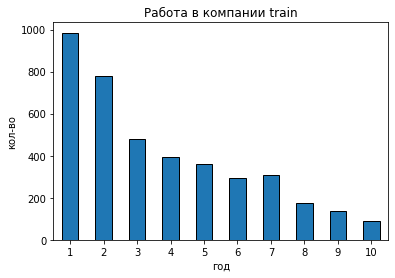

In [54]:
disk_bar_2(train_quit,'employment_years', 'Работа в компании' )

Видим уже знакомую кортину, довольно много 'молодых' сотрудников

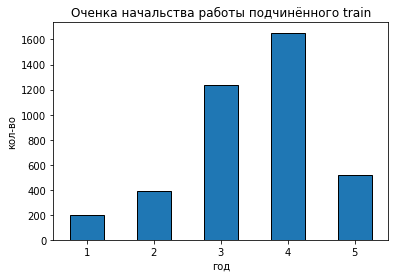

In [55]:
disk_bar_2(train_quit,'supervisor_evaluation', 'Оченка начальства работы подчинённого' )

Работают относительно не плохо

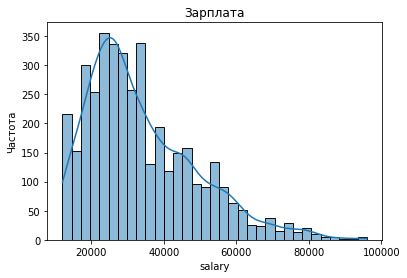

In [56]:
plot_feature_distribution_2(train_quit,'salary', 'Зарплата')

Все таже картина как и в предедущем DF

In [57]:
def plot_categorical_distribution_2(df, feature, title = None): # функция для построение графиков (котегориальные данные)
    _
    df_for_hi = df.groupby(feature).size()/len(df)    
    df_for_hi.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True,
                   title=title,  wedgeprops={'linewidth':1, 'edgecolor':'white'})
    
    

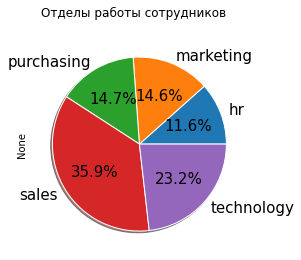

In [58]:
plot_categorical_distribution_2(train_quit, 'dept', 'Отделы работы сотрудников')

Все также

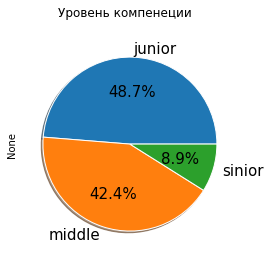

In [59]:
plot_categorical_distribution_2(train_quit, 'level', 'Уровень компенеции')

График похож на предедущий

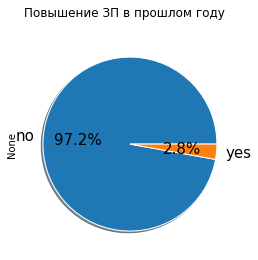

In [60]:
plot_categorical_distribution_2(train_quit, 'last_year_promo', 'Повышение ЗП в прошлом году')

Здесь сетуация ещё более плачевная.

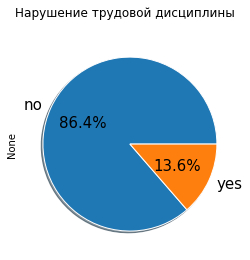

In [61]:
plot_categorical_distribution_2(train_quit, 'last_year_violations', 'Нарушение трудовой дисциплины')

Проблемы у компании

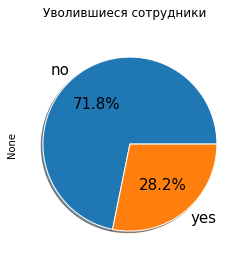

In [62]:
plot_categorical_distribution_2(train_quit, 'quit', 'Уволившиеся сотрудники')

Огромная текучка в районе 30%, компания не заинтересованна в сотрудниках

### Корреляция

In [63]:
train_quit.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no


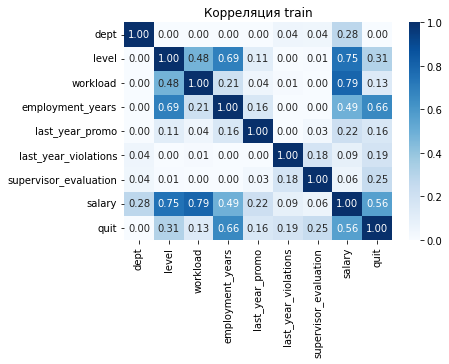

In [64]:
columns=train_quit.columns.to_list()
columns.remove('id')
interval_cols=['employment_years',  'salary']
sns.heatmap(train_quit[columns].phik_matrix(interval_cols=interval_cols), cmap="Blues", annot=True,fmt='.2f').set(title='Корреляция train')
pass

С корреляцией все хорошо 

### Мультиколлиниарность

In [65]:
vif(train_quit)

,Feature,vif
0,const,22.18
1,id,1.00
2,employment_years,1.29
3,supervisor_evaluation,1.00
4,salary,1.28


Мультиколлинеарности нет

Изучаем уволевшихся сотрудников для создания "портрета уволившегося"

In [66]:
columns = train_quit.columns.to_list()
columns.remove('id')

In [67]:
train_quit[columns].query('quit == "yes"').describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


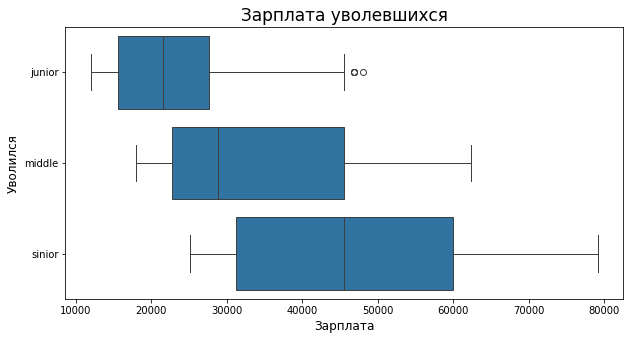

In [68]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_quit.query('quit == "yes"'), x='salary', y='level')

plt.title('Зарплата уволевшихся', size=17)
plt.xlabel('Зарплата', size=12)
plt.ylabel('Уволился', size=12)

plt.show()

Уровень зарплат уволившихся сотрудников находится в деапазоне от низких до чуть выше низких, но есть и небольшое колл-во сотрудников ушедших со средней ЗП

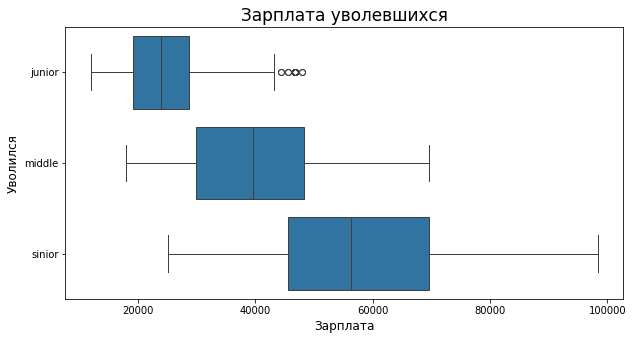

In [69]:
plt.figure(figsize=(10, 5))
#sns.boxplot(data=train[train['job_satisfaction_rate']<0.3], x='salary', y='level')
sns.boxplot(data=train, x='salary', y='level')
plt.title('Зарплата уволевшихся', size=17)
plt.xlabel('Зарплата', size=12)
plt.ylabel('Уволился', size=12)

plt.show()

Диапозон зарплат сотрудников которые хотят уйти укладывается в значения зарплат ушедших

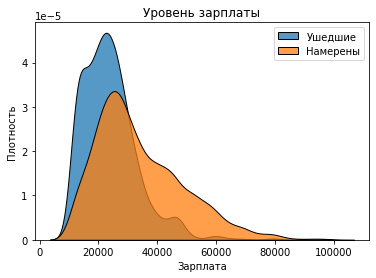

In [70]:
#sns.histplot(data = train_quit.query('quit == "yes"')['salary'], bins='auto', kde=True, multiple='dodge').set(title='Уровень зарплаты')
sns.kdeplot(data = train_quit.query('quit == "yes"')['salary'], label='Ушедшие', multiple="stack").set(title='Уровень зарплаты')  
sns.kdeplot(data = train['salary'], label='Намерены', multiple="stack").set(title='Уровень зарплаты')   
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Максимальлное кол-во это сотрудники с ЗП средней и ниже.

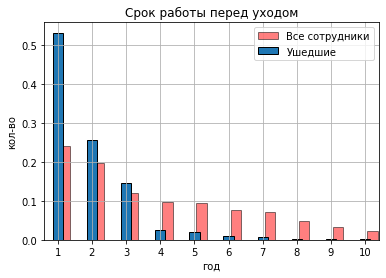

In [71]:
train.employment_years.value_counts(normalize=True).plot(kind = 'bar',  edgecolor='black', rot=0,ylabel='кол-во', xlabel='год',
                                                                                         alpha = 0.5, color='red', width=0.3,  position=-0.2)
train_quit.query('quit == "yes"').employment_years.value_counts(normalize=True).plot(kind = 'bar',  edgecolor='black', rot=0,ylabel='кол-во', xlabel='год', 
                                                                                         alpha =1, width=0.3, position=0.5, grid=True,)
plt.legend(['Все сотрудники', 'Ушедшие'])
plt.title('Срок работы перед уходом')
pass

Основная текучка это с низким стажем работы более 50% ушедших сотрудников уходят в первый год. 

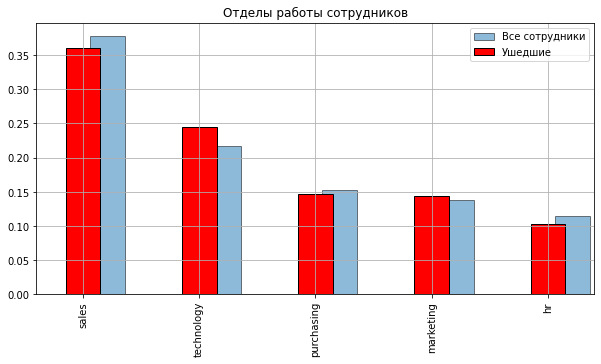

In [72]:
ax = plt.gca()
train.dept.value_counts(normalize=True).plot(kind='bar', alpha=0.5, figsize=(10,5), ec='black', ax=ax, rot=0, width=0.3, position=-0.2)
train_quit.query('quit == "yes"').dept.value_counts(normalize=True).plot(kind='bar', 
                                                                         alpha=1, figsize=(10,5), ec='black', 
                                                                         ax=ax,  color='red', grid=True, width=0.3, position=0.5)
plt.legend(['Все сотрудники', 'Ушедшие'])
plt.title('Отделы работы сотрудников')
pass


В основном уходят продавцы.

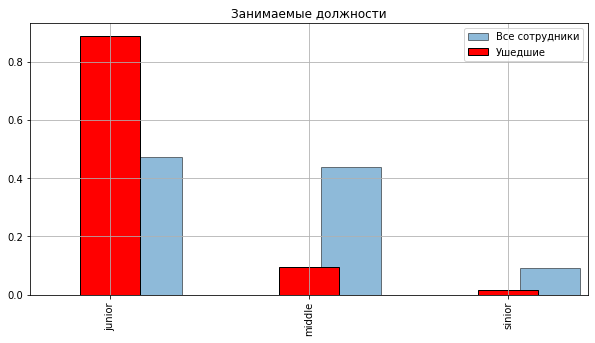

In [73]:
ax = plt.gca()
train.level.value_counts(normalize=True).plot(kind='bar', alpha=0.5, figsize=(10,5), ec='black', ax=ax, rot=0, width=0.3, position=-0.2)
train_quit.query('quit == "yes"').level.value_counts(normalize=True).plot(kind='bar', 
                                                                          alpha=1, figsize=(10,5), ec='black',
                                                                          ax=ax,  color='red', grid=True, width=0.3, position=0.5)
plt.legend(['Все сотрудники', 'Ушедшие'])
plt.title('Занимаемые должности')
pass

Сотрудники с низкой квалефикацией и средней уходят в первую очередь эксперты в последнюю.

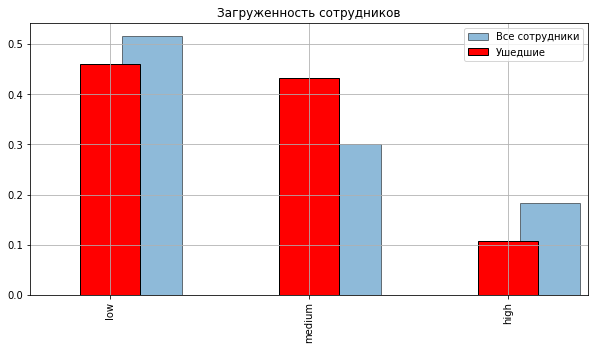

In [74]:
ax = plt.gca()
train.workload.value_counts(normalize=True).plot(kind='bar', alpha=0.5, figsize=(10,5), ec='black', ax=ax, rot=0, width=0.3, position=-0.2)
train_quit.query('quit == "yes"').workload.value_counts(normalize=True).plot(kind='bar', 
                                                                             alpha=1, figsize=(10,5), ec='black', 
                                                                             ax=ax,  color='red', grid=True, width=0.3, position=0.5)
plt.legend(['Все сотрудники', 'Ушедшие'])
plt.title('Загруженность сотрудников')
pass

Сотрудники со среденей загрузкой больше всего хотят уйти.

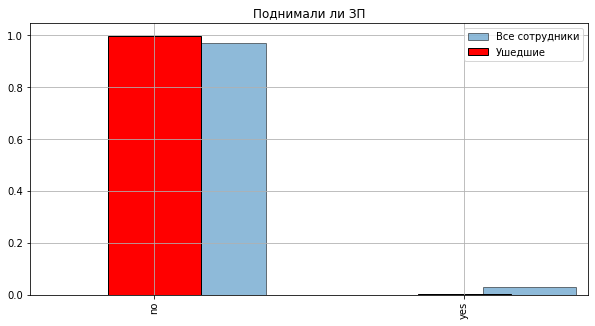

In [75]:
ax = plt.gca()
train.last_year_promo.value_counts(normalize=True).plot(kind='bar', alpha=0.5, figsize=(10,5), ec='black', ax=ax, rot=0, width=0.3, position=-0.2)
train_quit.query('quit == "yes"').last_year_promo.value_counts(normalize=True).plot(kind='bar', 
                                                                                    alpha=1, figsize=(10,5), ec='black',
                                                                                    ax=ax,  color='red', grid=True, width=0.3, position=0.5)
plt.legend(['Все сотрудники', 'Ушедшие'])
plt.title('Поднимали ли ЗП')
pass


Те кому подняли зарплату за последний год те остаются.

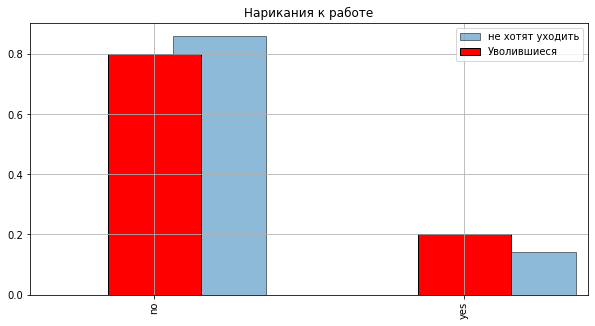

In [76]:
ax = plt.gca()
train.last_year_violations.value_counts(normalize=True).plot(kind='bar', alpha=0.5, figsize=(10,5), ec='black', ax=ax, rot=0, width=0.3, position=-0.2)
train_quit.query('quit == "yes"').last_year_violations.value_counts(normalize=True).plot(kind='bar', alpha=1, figsize=(10,5), ec='black', ax=ax,  color='red', grid=True, width=0.3, position=0.5)
plt.legend(['не хотят уходить', 'Уволившиеся'])
plt.title('Нарикания к работе')
pass


Судя по всему не всякий кто нарушает трудовой договор хочет уйти, но тот кто хочет уйти нарушает трудовой договор.

In [77]:
test_target_union = test_target_quit.set_index('id')  # объеденяем целевые признаки
test_target_new = test_target.set_index('id')
test_target_union = test_target_union.join(test_target_new)
test_target_union = test_target_union.reset_index()

In [78]:
test_target_union = test_target_union.set_index('id')  # добовляем целевые признаки к тестовой выборки
test_target_new = test.set_index('id')
test_target_union = test_target_union.join(test_target_new)
test_target_union = test_target_union.reset_index()

In [79]:
test_target_union.head()

,id,quit,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,999029,yes,0.35,technology,junior,medium,1,no,no,3,31200
1,372846,no,0.21,sales,middle,medium,10,no,yes,2,32400
2,726767,no,0.73,marketing,middle,low,7,no,no,4,20400
3,490105,no,0.62,purchasing,middle,low,7,no,no,4,19200
4,416898,yes,0.57,purchasing,junior,low,1,no,no,4,12000


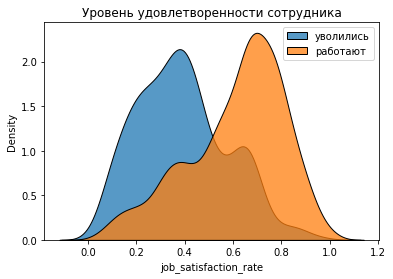

In [80]:
sns.kdeplot(data = test_target_union.query('quit== "yes"')['job_satisfaction_rate'], multiple="stack").set(title='Уровень удовлетворенности сотрудника') 
sns.kdeplot(data = test_target_union.query('quit== "no"')['job_satisfaction_rate'], multiple="stack").set(title='Уровень удовлетворенности сотрудника') 
plt.legend(['уволились', 'работают'])
pass

Сотрудки чаще всего увольняются те у кого уровень удовлетворенности условиями работы колеблится от 0,2 до 0,5. Утверждение можно считать условно верным.

##  Добавление нового входного признака

In [81]:
test_quit = test.set_index('id') # добавляем новый целевой признак
test_target_new = test_target_quit.set_index('id')
test_quit = test_quit.join(test_target_new)
test_quit = test_quit.reset_index()

In [82]:
test_quit = test_quit.sort_values(by='id') # сортитуем по "id"

In [83]:
model = RandomForestRegressor(max_depth=None, n_estimators=6, random_state=RANDOM_STATE)

model.fit(X_train_ridge, y_train_ridge)

test_quit['job_satisfaction_rate'] = model.predict(X_test_ridge) # добавил предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,no,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,no,0.821111
848,100503,purchasing,middle,high,5,no,no,4,55200,no,0.743889
524,100610,sales,middle,medium,5,no,no,4,43200,no,0.818635
476,100692,sales,middle,high,6,no,no,4,48000,no,0.692333


In [84]:
test_quit.query('job_satisfaction_rate <= 0.5') # Список людей готовые сменить работу

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1263,102320,sales,middle,high,4,no,no,3,57600,no,0.291667
1770,103221,sales,junior,medium,1,no,no,3,27600,yes,0.350326
1169,103342,sales,junior,medium,3,no,no,1,20400,yes,0.330873
1305,105159,sales,junior,medium,1,no,no,3,21600,yes,0.180162
1488,105314,hr,junior,low,1,no,no,2,15600,yes,0.127500
...,...,...,...,...,...,...,...,...,...,...,...
1439,995636,sales,sinior,low,7,no,no,3,31200,yes,0.448333
46,996005,sales,middle,low,3,no,no,4,19200,yes,0.491667
1088,997195,sales,middle,low,8,no,yes,3,27600,no,0.278333
1579,998900,marketing,middle,medium,7,no,no,3,45600,no,0.437500


In [85]:
train_quit = test_quit.sort_values(by='id')
model = RandomForestRegressor(max_depth=None, n_estimators=6, random_state=RANDOM_STATE)

model.fit(X_train_ridge, y_train_ridge)

train_quit['job_satisfaction_rate'] = model.predict(X_test_ridge) # добавил предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,no,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,no,0.821111
848,100503,purchasing,middle,high,5,no,no,4,55200,no,0.743889
524,100610,sales,middle,medium,5,no,no,4,43200,no,0.818635
476,100692,sales,middle,high,6,no,no,4,48000,no,0.692333


In [86]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,no,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,no,0.821111
848,100503,purchasing,middle,high,5,no,no,4,55200,no,0.743889
524,100610,sales,middle,medium,5,no,no,4,43200,no,0.818635
476,100692,sales,middle,high,6,no,no,4,48000,no,0.692333


In [87]:
test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,no,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,no,0.821111
848,100503,purchasing,middle,high,5,no,no,4,55200,no,0.743889
524,100610,sales,middle,medium,5,no,no,4,43200,no,0.818635
476,100692,sales,middle,high,6,no,no,4,48000,no,0.692333


##  Подготовка данных

In [88]:
le = LabelEncoder() # меняем на числовые значение поля quit в таблице train
le.fit(train_quit['quit'])
train_quit['quit'] = le.transform(train_quit['quit'])
train_quit.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,0,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,0,0.821111


In [89]:
le = LabelEncoder() # меняем на числовые значение поля quit в таблице test
le.fit(test_quit['quit'])
test_quit['quit'] = le.transform(test_quit['quit'])
test_quit.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,4,19200,0,0.860000
852,100480,marketing,junior,low,4,no,no,4,16800,0,0.821111


In [90]:
le = LabelEncoder() # меняем на числовые значение поля quit в таблице test
le.fit(test_target_quit['quit'])
test_target_quit['quit'] = le.transform(test_target_quit['quit'])
test_target_quit.head(2)

,id,quit
0,999029,1
1,372846,0


In [91]:
def prepare_data_2(X_train, y_train, X_test, y_test):# pipline подготовки данных
    
 
    ohe_columns = X_train.select_dtypes(include='object').columns.to_list()
    ohe_columns.remove('workload')
    ohe_columns.remove('level')
    ord_columns = ['workload', 'level']
    num_columns = X_train.select_dtypes(exclude = 'object').columns.to_list()    
    # создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
    # SimpleImputer + OHE
    ohe_pipe = Pipeline(
        [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
        ]
        )

    # создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
    # SimpleImputer + OE
    ord_pipe = Pipeline(
        [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ord',  OrdinalEncoder( 
                    handle_unknown='use_encoded_value', unknown_value=np.nan)
            ),
         ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ]
    )
    
    data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
    )
    
    X_train_ridge = X_train.copy()
    X_test_ridge  = X_test.copy()
    y_train_ridge = y_train.copy()
    y_test_ridge  = y_test.copy()
    
    X_train_ridge = pd.DataFrame(data_preprocessor.fit_transform(X_train_ridge), 
                                columns=data_preprocessor.get_feature_names_out()
                               )
    X_test_ridge = pd.DataFrame(data_preprocessor.transform(X_test_ridge), 
                                columns=data_preprocessor.get_feature_names_out()
                               )
    
    X_train_ridge = X_train_ridge.reset_index(drop=True)
    X_test_ridge  = X_test_ridge.reset_index(drop=True)
    y_train_ridge = y_train_ridge.reset_index(drop=True)
    y_test_ridge  = y_test_ridge.reset_index(drop=True)

    return X_train_ridge,  X_test_ridge,  y_train_ridge, y_test_ridge 

In [92]:
train_pip_2 = train_quit.copy()
train_pip_2 = train_quit.sort_values(by='id').drop(['id'], axis=1).drop_duplicates()
test_pip_2 = test_quit.copy()
test_pip_2 = test_quit.sort_values(by='id').drop(['id'], axis=1)
columns_x_2 = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
               'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [93]:
X_train_ridge_2,  X_test_ridge_2, y_train_ridge_2, y_test_ridge_2 = prepare_data_2(train_pip_2.drop(['quit',], axis=1)[columns_x_2]
                                                                                   , train_pip_2['quit'], 
                                                                                   test_pip_2[columns_x_2], 
                                                                                   test_target_quit.sort_values(by='id')['quit']) # запускаем ф-цию и получаем данные

## Обучение модели

### SVC

In [94]:
kernels = ['rbf','sigmoid', 'linear', 'poly']
for kernel in kernels:
    svc = SVC(kernel = 'rbf', random_state=RANDOM_STATE)
    roc_auc_cv = cross_val_score(svc, X_train_ridge_2, y_train_ridge_2, scoring='roc_auc').mean() 
    print('ROC-AUC', kernel, '= ', round(roc_auc_cv, 3) )

ROC-AUC rbf =  0.899
ROC-AUC sigmoid =  0.899
ROC-AUC linear =  0.899
ROC-AUC poly =  0.899


### Логическая регерессия

In [95]:
LR = LogisticRegression(random_state=RANDOM_STATE)
roc_auc_cv = cross_val_score(LR, X_train_ridge_2, y_train_ridge_2, scoring='roc_auc').mean()              

print('ROC-AUC = ', round(roc_auc_cv, 4))

ROC-AUC =  0.8961


### kNN

In [96]:
kNN = KNeighborsClassifier()
roc_auc_cv = cross_val_score(kNN, X_train_ridge_2, y_train_ridge_2, scoring='roc_auc').mean()  

print('ROC-AUC = ', round(roc_auc_cv, 4))

ROC-AUC =  0.8709


### Дерево решений

In [97]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
parameters =  {'min_samples_split': range(2, 6),
              'min_samples_leaf': range(1, 6),
              'max_depth': range(2, 6)
              }
gs = GridSearchCV(model, 
                  parameters, 
                  n_jobs=-1, 
                  cv=7, 
                  scoring= 'roc_auc') 
gs.fit(X_train_ridge_2, y_train_ridge_2)
print('ROC-AUC = ', round(gs.best_score_, 4))
print(gs.best_estimator_)

ROC-AUC =  0.9019
DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)


### Рандомный лес

In [98]:
model =  RandomForestClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': range(1, 7),
    'max_depth': [None] + [i for i in range(2, 7)]}
gs = GridSearchCV(model, 
                  parameters, 
                  n_jobs=-1, 
                  cv=5, 
                  scoring= 'roc_auc') 
gs.fit(X_train_ridge_2, y_train_ridge_2)
print('ROC-AUC = ', round(gs.best_score_, 4))
print(gs.best_estimator_)

ROC-AUC =  0.9042
RandomForestClassifier(max_depth=6, n_estimators=4, random_state=42)


Лучшая модель - случайный лес с гиперпараметрами max_depth=6, n_estimators=4.

### Проверка на тестовой выборке

In [100]:
model = RandomForestClassifier(max_depth=6, n_estimators=4, random_state=42)

model.fit(X_train_ridge_2, y_train_ridge_2)

test_predictions = model.predict_proba(X_test_ridge_2)

roc_auc = roc_auc_score(y_test_ridge_2, test_predictions[:,1]) 
print('ROC-AUC = ', roc_auc.round(4))

ROC-AUC =  0.9437


Значение ROC-AUC модели Случайный лес равно 0,93 -это значение уладывается в предел поставленной задачи ROC-AUC >= 91 на тестовой выборке.

##  Выводы

__Вывод:__ По результатам исслелований лучшем оказалалась модель Случайный лес с результатом __ROC-AUC = 0,94__  

Модель дерево оказалась лучше линейной регрессии, потому что у нас есть нелинейные зависимости между входными и целевым признаками.

### Общий вывод

Было поставлено две задачи:  
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.  
 

Были проведены следующие этапы и получены промежуточные выводы: 
1) Загрузка данных  
2) Предобработка данных, проверил на наличие пропусков и не заполненных значений также была проведена проверка название столбцов.   
Вывод: Есть небольшие недочеты с данными но ни чего кретичного нет, все поправил, пропуски заменил модовыми значениями.  
3) Проведен исследовательский анализ данных, добавил целевой признак.
Судя по полученным данным можно провести предворительные выводы, о том какие проблемы в компании, в компании приобладают сотрудники с малым стажем в компании, это говорт о высокой "текучки" кадров, побовляющее большенство сотрудников работают довольно хорошо, максимальное значение оценки руководства ближе к хорошо. Медианная зарплата находится в районе 30000 и судя по графику разница между работающими за копейки и получающие максимум бовольно большая. Удовлетворенность сотрудников работой в районе 0,5, не да ни нет. Намболее многочисленный отдет это отдел продаж почти 40% работников работают в этом отделе.  
Сотрудников с низкой квалификацией составляет 47,5%, со средней 43,6%, и высокой 9%. Довольно высокий показатель низкой загрудки сотрудников 30%, необходимо оптемизировать рабочий процес.
Стимуляции работать более усердно нет 97% сотрудников, а туда и пополи спесиалисты с высокой квалефикацией не получали стимул к плодотворной работе. 14% человек нарушали трудовой договор (у этой компании большие порлблемы)
4) Проведина проверка на корреляцию и мы можем сказать, что сильнее всего коррелируются два параметра "job_satisfaction_rate" и "supervisor_evaluation" как в таблице train так и в таблице union_test, но их значение не влияют друг на друга. Многие из этих параметров оказывают довольно слабое влияние, но если попробовать их объединить в одну группу, то, наверняка, можно будет построить хорошую предсказательную модел. Также проведена проверка на мультиколлениарность. Все признаки имеют значения VIF в диапазоне от 1 до 2,18. Это подтверждает вывод о том, что между признаками нет мультиколлинеарности. Самое высокое значение VIF (2,09) у признаков "job_satisfaction_rate" и чуть меньше "supervisor_evaluation", но даже эти значения находятся в приемлемом диапазоне. Нет признаков мультиколлинеарности между переменными.
5) Проведина процедура подготовки данных, была добавлена ф-ция для вычисления итоговой sMAPE, добовлен pipline для подготовки данных, Функция кросс валидации которая вычисляет sMAPE и были получены подготовленные данные.
6) Проверены три модели: __Линейная регрессия__  __smape =-26.804648__, __Дерево решений = -15,3__  и __Случайный лес = -14.55__  
По результатам анализа, лучшая модель: RandomForestRegressor с параметрами (max_depth=Nome, n_estimators=6, random_state=RANDOM_STATE).
7) Проверка лучшей модели на тестовой выборке показал среднее отклонение модели Случайный лес составляет 13% - это значение уладывается в предел поставленной задачи SMAPE ≤15 на тестовой выборке.  

Задача 2
1) Предобработка данных, показала что данными все в порядке аномалий нет.
2) Исследовательский анализ данных ни чего принципиально нового не показа, все очень похоже на исследовательский анализ их первой задачи. Но есть и интересные моменты такие как огромная текучка в районе 30%, компания не заинтересованна в сотрудниках. Проведен анализ корреляции и мультиколлениартности - все хорошо.
Уровень зарплат уволившихся сотрудников находится в деапазоне от низких до чуть выше низких, но есть и небольшое колл-во сотрудников ушедших со средней ЗП был построен boxplot диапозон зарплат сотрудников которые хотят уйти укладывается в значения зарплат ушедших. Максимальлное кол-во  ушедших это сотрудники с ЗП средней и ниже. Так же более 50% ушедших сотрудников уходят в первый год. В основном уходят продавцы, второе место занимают технари. Сотрудники с низкой квалефикацией и средней уходят в первую очередь эксперты в последнюю. График показал что сотрудники со средней нагрузкой больше всего хотят уйти. Еденицам кому подняли зарплату за последний год не собираются уходить остаются. Не всякий кто нарушает трудовой договор хочет уйти, но тот кто хочет уйти нарушает трудовой договор.
Проверил утверждение что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Сотрудки чаще всего увольняются с уровенем удовлетворенности от 0,2 до 0,5. Утверждение можно считать условно верным.
3) Добавил новый входнй признак, подготовил данные, добавил pipline, получил данные.
Провел обучение модели:  
SVC __ROC-AUC=0.9__  
Логическая регерессия __ROC-AUC=0.9__  
kNN __ROC-AUC=0.87__  
Дерево решений __ROC-AUC=0.91__  
Рандомный лес __ROC-AUC=0.9__  
__Вывод: По результатам исслелований лучшем оказалалась модель Случайный лес с результатом на тестовой выборке ROC-AUC=0,93__ это значение уладывается в предел поставленной задачи ROC-AUC>=91


__Итоговые выводы и рекоммендации:__ У компании давльно много проблем, высокая нагрузка для сотрудников при низкой заработной плате, что влечет за собой такое проблемы как высокую "текучку" (Большенство сотрудников отрабатывают не более года до ухода) сотрудников, низкеую дисциплину, очень хорошо было видно что почти все нарушители десцаплины уволились т.е. люди не дорожат работай и рабочим местом.  
Рекомендовал бы проводить ежегоджную индексацию ЗП, снижать нагрузку c junior сатрудиков или понять из ЗП. Чуль мень половины сотрудникв с низкой загрузкой, тоесть на джунов скидывают основную работу, отюда и высокая текучка и низкая стимуляция к работе. 